In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
SEED = 42

In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
tf.random.set_seed(SEED)

In [5]:
data_p_dir = 'data_p/s/'
image_dir = data_p_dir + 'image/'
label_dir = data_p_dir + 'label/'

In [6]:
image_file_paths = tf.data.Dataset.list_files(image_dir + '*.jpg', shuffle=False)
label_file_paths = tf.data.Dataset.list_files(label_dir + '*.jpg', shuffle=False)

dataset = tf.data.Dataset.zip((image_file_paths, label_file_paths))

# for i, l in dataset.take(3):
#     print(i, l)

2024-02-12 12:53:28.491456: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-12 12:53:28.491476: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-12 12:53:28.491482: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-12 12:53:28.491515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 12:53:28.491529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def process_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.
    return img

def process_label(path):
    mask = tf.io.read_file(path)
    img = tf.io.parse_tensor(mask, out_type=tf.float32)
    return img

def process_batch(image, label):
    X = process_img(image)
    y = process_label(label)
    return X, y

dataset = dataset.map(process_batch)

In [8]:
def plot_ds_element_overlay(background, overlay):
    fig, ax = plt.subplots()
    plt.imshow(background)
    ax.imshow(overlay, alpha=0.3)

def plot_ds_element(background, overlay):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(background)
    axs[1].imshow(overlay)
    plt.show()

# for i, m in dataset.skip(9).take(1):
#     plot_ds_element(i, m)

In [9]:
dataset = dataset.shuffle(buffer_size=10000, seed=SEED)

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8
num_samples = dataset.cardinality().numpy()

num_train = int(split_ratio * num_samples)
num_val = num_samples - num_train

# Split the dataset into training and validation sets
train_ds = dataset.take(num_train)
val_ds = dataset.skip(num_train)

In [10]:
model = sm.Unet('efficientnetb2', classes=1, activation='sigmoid')

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile('adam', sm.losses.DiceLoss(), metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 32)       128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 32)       0         ['stem_bn[0][0]']         

In [11]:
def callbacks():
    from datetime import datetime
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    checkpoint_path = "model_checkpoint.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    return [tensorboard_callback, checkpoint_callback]

In [12]:
train_ds = train_ds.batch(4).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(4).prefetch(buffer_size=tf.data.AUTOTUNE)

model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=callbacks())

Epoch 1/200


2024-02-12 12:53:38.786336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.9790 - iou_score: 0.0146 - f1-score: 0.0288
Epoch 1: val_loss improved from inf to 0.99395, saving model to model_checkpoint.h5
4/4 [==============================] - 24s 3s/step - loss: 0.9790 - iou_score: 0.0146 - f1-score: 0.0288 - val_loss: 0.9940 - val_iou_score: 0.0030 - val_f1-score: 0.0060
Epoch 2/200
4/4 [==============================] - ETA: 0s - loss: 0.9610 - iou_score: 0.0382 - f1-score: 0.0730
Epoch 2: val_loss improved from 0.99395 to 0.97568, saving model to model_checkpoint.h5
4/4 [==============================] - 9s 2s/step - loss: 0.9610 - iou_score: 0.0382 - f1-score: 0.0730 - val_loss: 0.9757 - val_iou_score: 0.0123 - val_f1-score: 0.0243
Epoch 3/200
4/4 [==============================] - ETA: 0s - loss: 0.9619 - iou_score: 0.0492 - f1-score: 0.0935
Epoch 3: val_loss did not improve from 0.97568
4/4 [==============================] - 9s 2s/step - loss: 0.9619 - iou_score: 0.0492 - f1-score: 0.0935 - val_los

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>


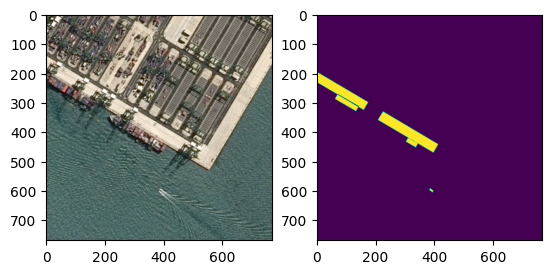

1/1 [==============================] - 0s 476ms/step


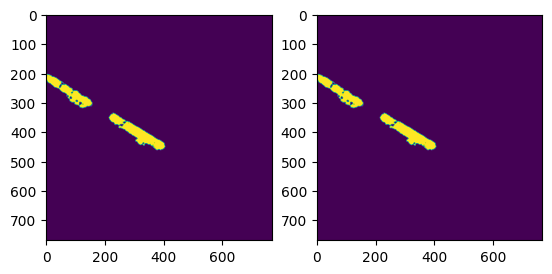

In [20]:
SKIP = 6
d = tf.data.Dataset.zip((image_file_paths, label_file_paths)).map(process_batch)

item = d.batch(1).skip(SKIP).take(1)
print(item)

for i, l in item:
    plot_ds_element(i[0], l[0])

for i, l in item:
    p = model.predict(i)
    plot_ds_element(p[0], p[0])